In [1]:
import pandas as pd
import numpy as np
import pulp
import random
import matplotlib.pyplot as plt

In [37]:
# Create the properties of the offices
officeData = pd.DataFrame( { 'officeID': np.arange(0, 12)})
officeData['roomID'] = officeData['officeID']//4
officeData['isLeft'] = officeData['officeID']%2
officeData = officeData.set_index('officeID')
officeData['dum']=0
NRooms = len(officeData['roomID'].unique())
print(NRooms)
officeData

3


,roomID,isLeft,dum
officeID,,,
0,0,0,0
1,0,1,0
2,0,0,0
3,0,1,0
4,1,0,0
5,1,1,0
6,1,0,0
7,1,1,0
8,2,0,0


In [28]:
persoData = pd.DataFrame( {'persoID' : np.arange(8)})
persoData['isTall'] = np.random.choice([0, 1], size=(8,1), p=[0.7, 0.3] )
persoData['service'] = np.random.randint(0, 3, (8,1) )
persoData = persoData.set_index('persoID')
NServ = len(persoData['service'].unique())
print('NServ : ', NServ)
persoData

NServ :  3


,isTall,service
persoID,,
0,1,0
1,1,2
2,1,0
3,1,2
4,1,1
5,0,0
6,0,1
7,0,1


officeOccupancy represent the placement variable. 

$$ \text{officeOccupancy}_{p,o} = \begin{cases} 1 &\text{if person p is seated in office o}\\ 0 &\text{otherwise}\end{cases} $$


In [4]:
#Creating variables
officeOccupancy = pulp.LpVariable.matrix("officeOccupancy"
                                         ,(list(persoData.index), list(officeData.index))
                                         ,cat='Binary')

$$ \delta_{s,r} = \begin{cases} 1 &\text{if at least one person of service s is seating in room r}\\ 0 &\text{otherwise}\end{cases} $$


In [5]:
#Creating delta variables
delta = pulp.LpVariable.matrix("delta"
                                ,(np.arange(NServ), np.arange(NRooms))
                                ,cat='Binary')


The purpose of R is to filter the offices which belong to a given bloc of offices. In a given column, which represent a room, the 1 represent the offices which belong to this room.

$$ R_{o,r} = \begin{cases} 1 &\text{if office o belongs to room r}\\ 0 &\text{otherwise}\end{cases} $$

$$XR$$ will represent the number of persons in each room

In [6]:
R = pd.pivot_table(officeData, values=['isLeft'], columns='roomID', index=officeData.index, aggfunc='count').fillna(0).astype(int).values
R

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

The purpose of S is to filter the persons according to their services. Each line represent the list of services in which the given person belongs to.

$$ S_{p,s} = \begin{cases} 1 &\text{if person p belongs to service s}\\ 0 &\text{otherwise}\end{cases} $$

$$SX$$ represent the service distribution accross offices.

In [30]:
S = pd.pivot_table(persoData, values='isTall', columns='service', index=persoData.index, aggfunc='count').fillna(0).astype(int).values.T
S

array([[1, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 0]])

Linear programming does not accept 'if then' structure, needed for the definition of $\delta$. 
Instead, the structure will be mocked using the sum of person from a service in a given room ($\Delta$).
    
$\Delta_{s,r}$ represents the number of persons from service s seated in room r. 
It can be computed wit the formula $ \Delta = S.\text{officeOccupancy}.R $.


$$ \delta_{s,r} = \begin{cases} 1 &\text{if } \Delta_{s,r}>0\\ 0 &\text{otherwise}\end{cases} $$

This conditional values of $\delta$ are equivalent of the following set of linear constraints :
$$\delta \geq \frac{\Delta}{K} $$
$$\delta \leq \Delta$$
with $K$ the largest value that $\Delta$ can take : the total amount of person to seat.

In [21]:
Delta = np.dot(np.dot(S, officeOccupancy),R)
#Delta

T represent the room distribution of tall people.

$$ T_{p} = \begin{cases} 1 &\text{if person p is tall}\\ 0 &\text{otherwise}\end{cases} $$



In [44]:
T = pd.pivot_table(persoData, columns='isTall', values='service', index=persoData.index, aggfunc='count').fillna(0).astype(int).values.T[1]
T

array([1, 1, 1, 1, 1, 0, 0, 0])

L filters the offices in each room according the their leftiness or rightness.

$$ L_{o,lr} = \begin{cases} 1 &\text{office o belongs to room r with leftiness l}\\ 0 &\text{otherwise}\end{cases} $$


In [45]:
L = pd.pivot_table(officeData, columns=['isLeft', 'roomID'], values=['dum'], index=officeData.index, aggfunc='count').fillna(0).astype(int).values
L

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1]])

Similarly to $\Delta$, legs represents the number of tall people who occupy a left or right office in a given room.

In [46]:
legs = np.dot(np.dot(T,officeOccupancy),L)
legs

array([ 1*officeOccupancy_0_0 + 1*officeOccupancy_0_2 + 1*officeOccupancy_1_0 + 1*officeOccupancy_1_2 + 1*officeOccupancy_2_0 + 1*officeOccupancy_2_2 + 1*officeOccupancy_3_0 + 1*officeOccupancy_3_2 + 1*officeOccupancy_4_0 + 1*officeOccupancy_4_2 + 0,
       1*officeOccupancy_0_4 + 1*officeOccupancy_0_6 + 1*officeOccupancy_1_4 + 1*officeOccupancy_1_6 + 1*officeOccupancy_2_4 + 1*officeOccupancy_2_6 + 1*officeOccupancy_3_4 + 1*officeOccupancy_3_6 + 1*officeOccupancy_4_4 + 1*officeOccupancy_4_6 + 0,
       1*officeOccupancy_0_10 + 1*officeOccupancy_0_8 + 1*officeOccupancy_1_10 + 1*officeOccupancy_1_8 + 1*officeOccupancy_2_10 + 1*officeOccupancy_2_8 + 1*officeOccupancy_3_10 + 1*officeOccupancy_3_8 + 1*officeOccupancy_4_10 + 1*officeOccupancy_4_8 + 0,
       1*officeOccupancy_0_1 + 1*officeOccupancy_0_3 + 1*officeOccupancy_1_1 + 1*officeOccupancy_1_3 + 1*officeOccupancy_2_1 + 1*officeOccupancy_2_3 + 1*officeOccupancy_3_1 + 1*officeOccupancy_3_3 + 1*officeOccupancy_4_1 + 1*officeOccupancy_4_3

In [47]:
model = pulp.LpProblem("Office setting maximizing happyness", pulp.LpMaximize)


#Objective function : maximising the number of people seated (constrained anyway)
model += pulp.lpSum( officeOccupancy ) + np.sum(delta)

#Each perso is set once
for s  in np.sum(officeOccupancy, axis=0) :
#    print(s)
    model += s <= 1
    
#Each room is set at least once
for s in np.sum(officeOccupancy, axis=1) :
#    print(s)
    model += s == 1
        
#Constraint of delta
for s in range( NServ) :
    for j in range( NRooms ) :
        model += delta[s][j] >= Delta[s][j]/len(persoData)
        model += delta[s][j] <= Delta[s][j]
        
#We imose two tall people not to be in front of each other
for l in legs :
    model += l <=1

In [48]:
model.solve()
pulp.LpStatus[model.status]

'Optimal'

In [51]:
#Print results
x = []
y = []
t = []
for iPerso in persoData.index :
    for iRoom in officeData.index : 
        if officeOccupancy[iPerso][iRoom].varValue   :
            print( iPerso, iRoom)
            y.append(persoData.loc[iPerso,'service']+1)
            x.append(iRoom)
            t.append(persoData.loc[iPerso, 'isTall'])

0 5
1 0
2 3
3 8
4 6
5 1
6 4
7 2


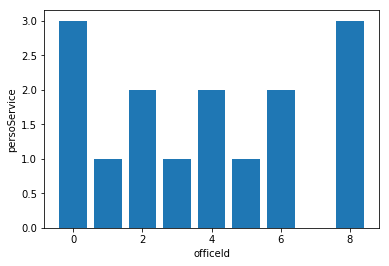

In [50]:
plt.figure()
plt.bar(x,y)
plt.xlabel('officeId')
plt.ylabel('persoService')
plt.savefig('maximiseDispersion.pdf')
plt.show()

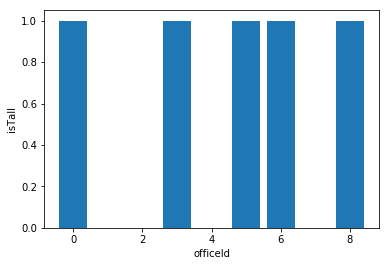

In [52]:
plt.figure()
plt.bar(x,t)
plt.xlabel('officeId')
plt.ylabel('isTall')
#plt.savefig('maximiseDispersion.pdf')
plt.show()